In [6]:
import datetime
from xml.etree import ElementTree as ET
import requests
from requests.auth import HTTPDigestAuth
import numpy as np
import time
import json
import pandas as pd

In [37]:
import mpld3
# mpld3.enable_notebook()
%matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15,5)

In [73]:
# When power is negative it means it's consuming from the grid. Positive is backfeeding
class SonnenInterface():

    def __init__ (self, serial = None, auth_token = None):
        self.serial = serial
        self.token = auth_token
        self.url_ini = 'https://core-api.sonnenbatterie.de/proxy/'
        self.headers = { 'Accept': 'application/vnd.sonnenbatterie.api.core.v1+json',
    'Authorization': 'Bearer '+self.token,}
        
    
    def get_status(self):
        status_endpoint = '/api/v1/status'
        try:
            resp = requests.get(self.url_ini + self.serial + status_endpoint, headers=self.headers)
            resp.raise_for_status()
            
        except requests.exceptions.HTTPError as err:
            print(err)
            
        return resp.json()
    
    
# Backup:
# Intended to maintain an energy reserve for situations where the Grid is no longer available. During the off-grid 
# period the energy would be dispensed to supply the demand of power from all the essential loads. 
# Load management can be enabled to further extend the life of the batteries by the Developers.

    def enable_backup_mode(self):
        backup_endpoint = '/api/setting?EM_OperatingMode=7'
        try:
            resp = requests.get(self.url_ini + self.serial + backup_endpoint, headers=self.headers)
            resp.raise_for_status()
            
        except requests.exceptions.HTTPError as err:
            print(err)
            
        return resp.json()


# Self-Consumption:
# The ecoLinx monitors all energy sources (Grid, PV, Generator), loads, and Energy Reserve Percentage 
# in order to minimize purchase of energy from the Grid.

    def enable_self_consumption(self):
        sc_endpoint = '/api/setting?EM_OperatingMode=8'
        try:
            resp = requests.get(self.url_ini + self.serial + sc_endpoint, headers=self.headers)
            resp.raise_for_status()
        
        except requests.exceptions.HTTPError as err:
            print(err)
        
        return resp.json()

# Time of Use (TOU):
# This mode allows users to set time windows where it is preferred to employ the use of stored energy 
# (from PV) rather than consume from the grid.    
    
    def enable_tou(self):
        tou_endpoint = '/api/setting?EM_OperatingMode=10'
        try:
            resp = requests.get(self.url_ini + self.serial + tou_endpoint, headers=self.headers)
            resp.raise_for_status()
        
        except requests.exceptions.HTTPError as err:
            print(err)
        
        return resp.json()
    
    def tou_grid_feedin(self, value=0):
        # value = 0 disable charging from grid
        # value = 1 enable charging from grid
        grid_feedin_endpoint = '/api/setting?EM_US_GRID_ENABLED=' + str(value)
        try:
            resp = requests.get(self.url_ini + self.serial + grid_feedin_endpoint, headers=self.headers)
            resp.raise_for_status()
        
        except requests.exceptions.HTTPError as err:
            print(err)
        
        return resp.json()
    
    def tou_window(self, pk_start='[16:00]', pk_end='[21:00]', opk_start='[21:01]'):
        # value format = [HH:00] in 24hrs format
        tou_pk_start_endpoint = '/api/setting?EM_US_PEAK_HOUR_START_TIME=' + pk_start
        tou_pk_end_endpoint = '/api/setting?EM_US_PEAK_HOUR_END_TIME=' + pk_end
        tou_opk_start_endpoint = '/api/setting?EM_US_LOW_TARIFF_CHARGE_TIME=' + opk_start
        try:
            resp1 = requests.get(self.url_ini + self.serial + tou_pk_start_endpoint, headers=self.headers)
            resp1.raise_for_status()
            resp2 = requests.get(self.url_ini + self.serial + tou_pk_end_endpoint, headers=self.headers)
            resp2.raise_for_status()
            resp3 = requests.get(self.url_ini + self.serial + tou_opk_start_endpoint, headers=self.headers)
            resp3.raise_for_status()
        
        except requests.exceptions.HTTPError as err:
            print(err)
        
        return [resp1.json(),resp2.json(),resp3.json()]
        
        

# Manual Mode
# This mode allows the user to manually charge or discharge the batteries. The user needs to provide the 
# value for charging or discharging and based on the value, the ecoLinx system will charge until it reaches 
# 100% or discharge until it reaches 0% User SOC (unless stopped by the user by changing the charge/discharge 
# value to 0).

    # Enabled by default
    def enable_manual_mode(self):
        manual_endpoint = '/api/setting?EM_OperatingMode=1'
        try:
            resp = requests.get(self.url_ini + self.serial + manual_endpoint, headers=self.headers)
            resp.raise_for_status()
      
        except requests.exceptions.HTTPError as err:
            print(err)
            
        return resp.json()
    
    
    def manual_mode_control(self, mode = 'charge', value = '0'):
        control_endpoint = '/api/v1/setpoint/'
        # Checking if system is in off-grid mode
        voltage = SonnenInterface(serial = self.serial, auth_token = token).get_status()['Uac']
        
        if voltage == 0:
            print('Battery is in off-grid mode... Cannot execute the command')
            return {}
        
        else:
            try:
                resp = requests.get(self.url_ini + self.serial + control_endpoint+mode+'/'+value, headers=self.headers)
                resp.raise_for_status()

            except requests.exceptions.HTTPError as err:
                print(err)

            return resp.json()
        
        

In [71]:
farm = SonnenInterface(serial = serial5, auth_token = token)
resp = farm.enable_tou()
print(resp)


{'status': '0'}


In [76]:
# farm.tou_grid_feedin()
farm.tou_window()
# farm.get_status()
# serial5

[{'status': '0'}, {'status': '0'}, {'status': '0'}]

In [3]:
token = '5db92cf858eebce34af146974f49f4d40ec699b99372546c0af628fb48133f61'
serial = '108547'
# serial = '67670'
SonnenInterface(serial = serial, auth_token = token).get_status()

{'BackupBuffer': '12',
 'BatteryCharging': True,
 'BatteryDischarging': False,
 'Consumption_W': 66,
 'Fac': 60,
 'FlowConsumptionBattery': False,
 'FlowConsumptionGrid': False,
 'FlowConsumptionProduction': True,
 'FlowGridBattery': True,
 'FlowProductionBattery': True,
 'FlowProductionGrid': False,
 'GridFeedIn_W': -96,
 'IsSystemInstalled': 1,
 'OperatingMode': '10',
 'Pac_total_W': -600,
 'Production_W': 570,
 'RSOC': 82,
 'SystemStatus': 'OnGrid',
 'Timestamp': '2020-01-26 11:25:33',
 'USOC': 78,
 'Uac': 242,
 'Ubat': 50}

In [ ]:
token = '5db92cf858eebce34af146974f49f4d40ec699b99372546c0af628fb48133f61'
batt1_status = SonnenInterface(serial = '67682', auth_token = token).get_status()
batt2_status = SonnenInterface(serial = '67670', auth_token = token).get_status()
print('batt1 status: ', batt1_status)
print('batt2 status: ', batt2_status)

In [5]:
mode = 'charge'
value = '4000'
serial2 = '67670'
serial1 = '67682'
batt1 = SonnenInterface(serial = serial1, auth_token = token).manual_mode_control(mode, value)
batt2 = SonnenInterface(serial = serial2, auth_token = token).manual_mode_control(mode, value)
print('batt1: ', batt1)
print('batt2: ', batt2)

batt1:  {'ReturnCode': '0'}
batt2:  {'ReturnCode': '0'}


In [7]:
mode = 'charge'
value = '0'
# serial = '67670'
serial = '67682'
resp = SonnenInterface(serial = serial, auth_token = token).manual_mode_control(mode, value)
print(resp)

{'ReturnCode': '0'}


In [ ]:
status = SonnenInterface(serial = serial, auth_token = token).get_status()

In [ ]:
status

In [ ]:
int(resp['ReturnCode'])

In [ ]:
batt1_status['USOC']>70

In [23]:
i=0
while i==0:
    try:
        batt1_status = SonnenInterface(serial = '67682', auth_token = token).get_status()
        batt2_status = SonnenInterface(serial = '67670', auth_token = token).get_status()
        
    except requests.exceptions.HTTPError as err:
        print('Error: ', err)
        
    print('Battery 1 SOC: ', batt1_status['USOC'])
    print('Battery 2 SOC: ', batt2_status['USOC'])
    
    if batt2_status['USOC']<20:
        try:
            print('charging...')
            batt1 = SonnenInterface(serial = serial1, auth_token = token).manual_mode_control('charge', '1000')
            batt2 = SonnenInterface(serial = serial2, auth_token = token).manual_mode_control('charge', '1000')
            print(batt2)
            i=1
        
        except requests.exceptions.HTTPError as err:
            print('Error: ', err)
    else:
        print('discharging...')
        batt1 = SonnenInterface(serial = serial1, auth_token = token).manual_mode_control('discharge', '3000')
        batt2 = SonnenInterface(serial = serial2, auth_token = token).manual_mode_control('discharge', '3000')
            
    time.sleep(480)

print('Exited while loop')
time.sleep(900)
batt1 = SonnenInterface(serial = serial1, auth_token = token).manual_mode_control('charge', '1000')
batt2 = SonnenInterface(serial = serial2, auth_token = token).manual_mode_control('charge', '1000')
print('batt1: ', batt1)
print('batt2: ', batt2)

Battery 1 SOC:  92
Battery 2 SOC:  76
discharging...
Battery 1 SOC:  88
Battery 2 SOC:  73
discharging...
Battery 1 SOC:  85
Battery 2 SOC:  69
discharging...
Battery 1 SOC:  82
Battery 2 SOC:  67
discharging...
Battery 1 SOC:  80
Battery 2 SOC:  64
discharging...
Battery 1 SOC:  77
Battery 2 SOC:  61
discharging...
Battery 1 SOC:  74
Battery 2 SOC:  59
discharging...
Battery 1 SOC:  71
Battery 2 SOC:  56
discharging...
Battery 1 SOC:  68
Battery 2 SOC:  53
discharging...
Battery 1 SOC:  65
Battery 2 SOC:  49
discharging...
Battery 1 SOC:  62
Battery 2 SOC:  47
discharging...
Battery 1 SOC:  60
Battery 2 SOC:  44
discharging...
Battery 1 SOC:  57
Battery 2 SOC:  41
discharging...
Battery 1 SOC:  54
Battery 2 SOC:  38
discharging...
Battery 1 SOC:  52
Battery 2 SOC:  35
discharging...
Battery 1 SOC:  48
Battery 2 SOC:  33
discharging...
Battery 1 SOC:  45
Battery 2 SOC:  29
discharging...
Battery 1 SOC:  43
Battery 2 SOC:  26
discharging...
Battery 1 SOC:  40
Battery 2 SOC:  23
discharg

In [ ]:
batt1_status['serial'] = '1111'

In [ ]:
batt1_status

In [ ]:
import datetime
ts = 1559951809886
fmt = "%Y-%m-%d %H:%M:%S"
t = datetime.datetime.fromtimestamp(float(ts)/1000.)

In [ ]:
t.strftime(fmt)

In [ ]:
140*1.73


In [61]:
serial1 = '108547'    # Sri
serial2 = '108544'    # Rakesh
# serial3 = '108543'  # Narinder
serial4 = '108540'    # Naishdah
serial5 = '67682'     # Farm

SonnenInterface(serial = serial5, auth_token = token).get_status()

{'Consumption_W': 0,
 'Fac': 60,
 'GridFeedIn_W': 0,
 'IsSystemInstalled': 1,
 'Production_W': 375,
 'RSOC': 97,
 'Timestamp': '2020-01-26 14:33:31',
 'USOC': 97,
 'Uac': 254,
 'Ubat': 53}

In [50]:
sonnen_8547 = pd.read_csv('108547_sonnen.csv')
sonnen_8547['### UNIX-Timestamp'] = sonnen_8547['### UNIX-Timestamp']+7200
sonnen_8547['datetime'] = sonnen_8547['### UNIX-Timestamp']
sonnen_8547['datetime'] = pd.to_datetime(sonnen_8547['datetime'],unit='s')
sonnen_8547['diff_sec'] = (sonnen_8547['### UNIX-Timestamp'].diff())/3600
sonnen_8547['Discharge(W)'] = sonnen_8547[' Discharge(Wh)']/sonnen_8547['diff_sec']
sonnen_8547['Charge(W)'] = sonnen_8547[' Charge(Wh)']/sonnen_8547['diff_sec']
sonnen_8547['Production(W)'] = sonnen_8547[' Production(Wh)']/sonnen_8547['diff_sec']
sonnen_8547['Consumption(W)'] = sonnen_8547[' Consumption(Wh)']/sonnen_8547['diff_sec']
sonnen_8547.set_index('datetime', inplace=True)
sonnen_8547 = sonnen_8547.sort_index()
df_8547 = sonnen_8547.drop(columns=['### UNIX-Timestamp', ' Date/Time', ' Discharge(Wh)', ' Charge(Wh)', ' Production(Wh)', ' Consumption(Wh)', 'diff_sec'])
df_8547.dropna(inplace=True)
df_8547.head()

,Feed-in(Wh),From grid(Wh),State of Charge(%),Discharge(W),Charge(W),Production(W),Consumption(W)
datetime,,,,,,,
2019-12-26 12:55:00,3.72,0.0,76,0.0,918.00,1141.20,0.0
2019-12-26 12:59:00,9.60,0.0,76,0.0,993.00,1137.00,0.0
2019-12-26 13:00:00,3.37,0.0,76,0.0,931.80,1134.00,0.0
2019-12-26 13:06:00,2.92,0.0,77,0.0,158.30,187.50,0.0
2019-12-26 13:10:00,14.06,0.0,77,0.0,913.05,1123.95,0.0


<IPython.core.display.Javascript object>


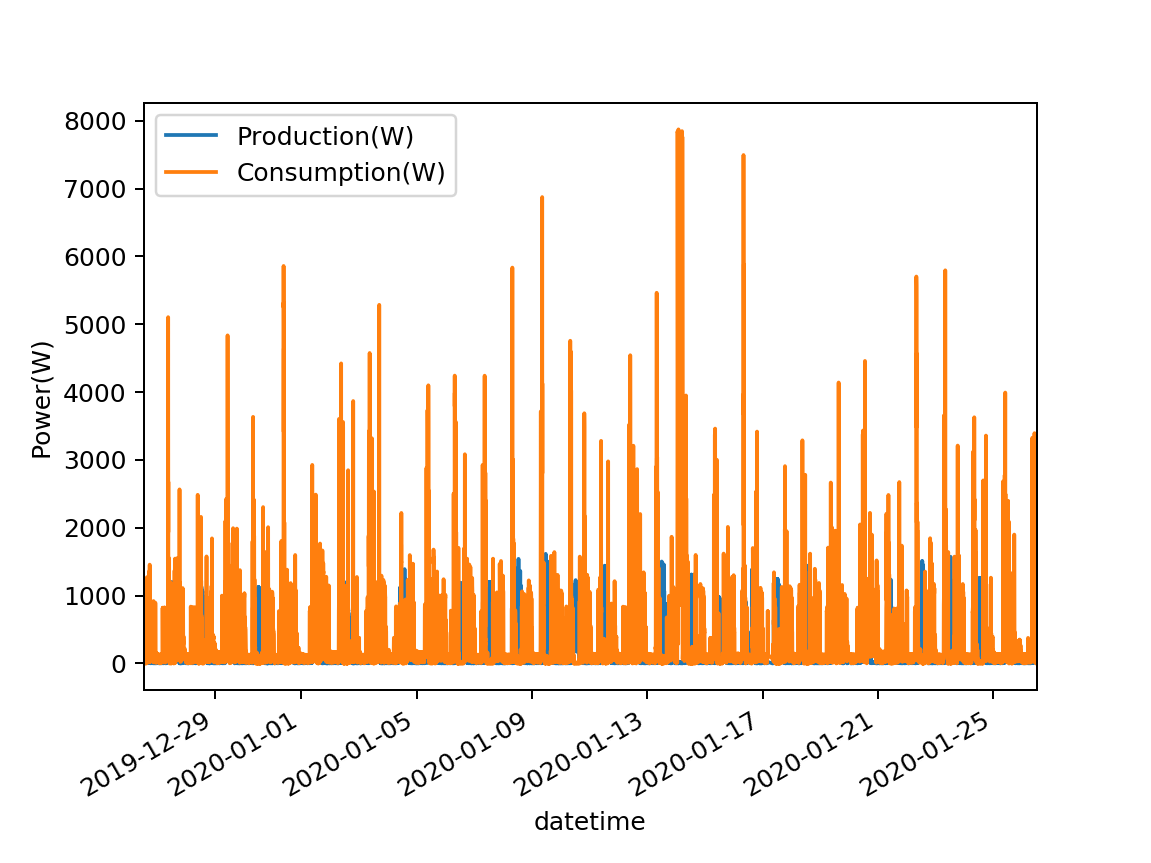

[Text(0, 0.5, 'Power(W)')]

In [60]:
ax = df_8547[['Production(W)', 'Consumption(W)']].plot()
ax.set(xlabel = 'datetime')
ax.set(ylabel = 'Power(W)')

<IPython.core.display.Javascript object>


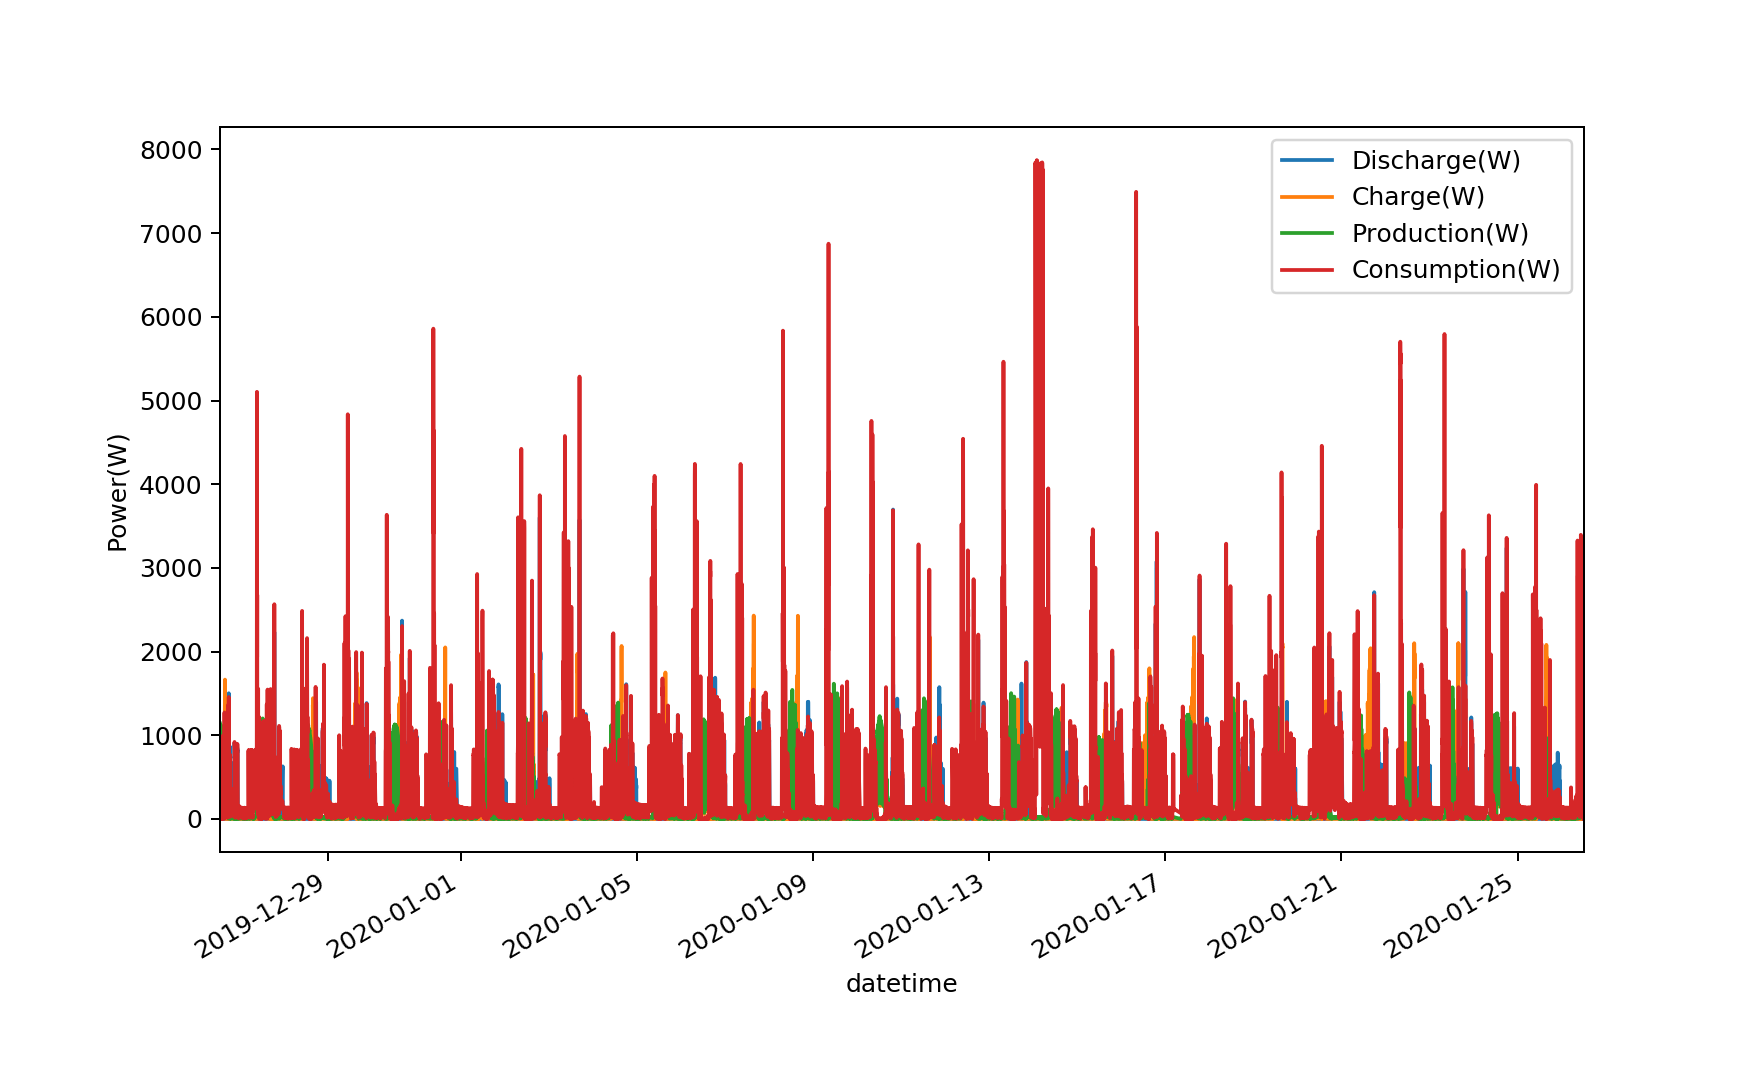

[Text(0, 0.5, 'Power(W)')]

In [59]:
ax1 = df_8547[['Discharge(W)', 'Charge(W)']].plot()
ax1.set(xlabel = 'datetime')
ax1.set(ylabel = 'Power(W)')
# df_8547['Discharge(W)'].plot()
# df_8547['Charge(W)'].plot()
# df_8547['Production(W)'].plot()
# df_8547['Consumption(W)'].plot()

In [157]:
ra

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<IPython.core.display.Javascript object>


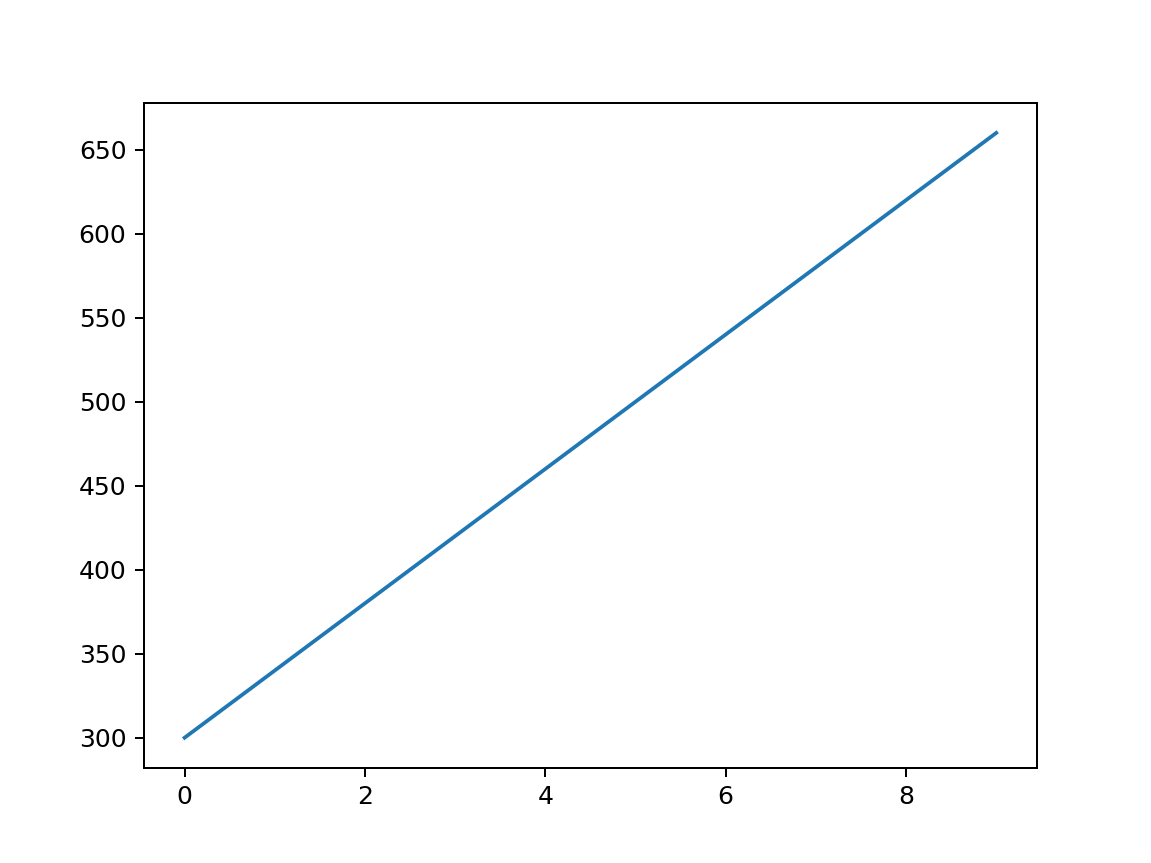

In [158]:
# reg = pd.read_csv('reg_sig.csv')
ra = np.arange(10)
ramp = (0.4*ra+3)*100
plt.plot(ra,ramp)

In [127]:
signal = abs(reg[0:54])
signal.loc[signal['reg(W)']<200, 'reg(W)'] = 0
sig = signal.values
sig[10]

array([343.005])

In [129]:
len(sig)

54

# Naishadh Original

In [84]:
token = '5db92cf858eebce34af146974f49f4d40ec699b99372546c0af628fb48133f61'
serial_Naishadh = '108540'    # Naishdah
naishadh = SonnenInterface(serial = serial_Naishadh, auth_token = token)

In [85]:
naishadh.get_status()

{'BackupBuffer': '40',
 'BatteryCharging': False,
 'BatteryDischarging': False,
 'Consumption_W': 750,
 'Fac': 60,
 'FlowConsumptionBattery': False,
 'FlowConsumptionGrid': True,
 'FlowConsumptionProduction': True,
 'FlowGridBattery': False,
 'FlowProductionBattery': False,
 'FlowProductionGrid': False,
 'GridFeedIn_W': -68,
 'IsSystemInstalled': 1,
 'OperatingMode': '10',
 'Pac_total_W': 0,
 'Production_W': 682,
 'RSOC': 100,
 'SystemStatus': 'OnGrid',
 'Timestamp': '2020-01-26 15:23:54',
 'USOC': 100,
 'Uac': 247,
 'Ubat': 50}

In [160]:
naishadh.enable_manual_mode()
# naishadh.manual_mode_control('discharge', '400')
# naishadh.enable_tou()
# naishadh.tou_grid_feedin()
# naishadh.tou_window()


{'ReturnCode': '0'}

In [193]:
# Ramping Signal
ra = np.arange(5)
ramp = (2*ra+3)*120
ramp


# plt.plot(ra,ramp)
naishadh.enable_manual_mode()
naishadh.manual_mode_control('discharge', '0')
time.sleep(240)
status = naishadh.get_status()
print(status)
for i in ramp:
    val = str(i)
    print(val)
    naishadh.manual_mode_control('discharge', val)
    print(datetime.now())
    time.sleep(120)


naishadh.manual_mode_control('discharge', '0')
time.sleep(240)
naishadh.enable_tou()
naishadh.tou_grid_feedin()
naishadh.tou_window()

360
2020-01-27 08:09:53.061323
600
2020-01-27 08:11:57.056348
840
2020-01-27 08:14:01.131262
1080
2020-01-27 08:16:03.882403
1320
2020-01-27 08:18:06.956243


[{'status': '0'}, {'status': '0'}, {'status': '0'}]

In [172]:
# Ramping Signal
ra = np.arange(10)
ramp = (0.4*ra+3)*100
# plt.plot(ra,ramp)
naishadh.enable_manual_mode()
naishadh.manual_mode_control('discharge', '0')
time.sleep(360)
for i in ramp:
    val = str(i)
    print(val)
    print(datetime.now())
    naishadh.manual_mode_control('discharge', val)
    time.sleep(60)

naishadh.enable_tou()
naishadh.tou_grid_feedin()
naishadh.tou_window()

300.0
2020-01-26 18:35:24.819481
340.0
2020-01-26 18:36:27.970880
380.0
2020-01-26 18:37:32.981516
420.0
2020-01-26 18:38:36.956674
459.99999999999994
2020-01-26 18:39:40.294959
500.0
2020-01-26 18:40:46.166659
540.0
2020-01-26 18:41:54.134667
580.0000000000001
2020-01-26 18:42:57.097391
620.0
2020-01-26 18:44:00.910079
660.0
2020-01-26 18:45:05.170824


[{'status': '0'}, {'status': '0'}, {'status': '0'}]

In [194]:
# Regulation Signal
# reg = pd.read_csv('reg_sig.csv')

reg_signal = pd.read_csv('rega-2min.csv')
reg = reg_signal['Reg'].values
regA = reg[30:46]

a = range(len(regA))
naishadh.enable_manual_mode()
naishadh.manual_mode_control('discharge', '0')
for i in a:
    val = str(regA[i])
    print(val)
    naishadh.manual_mode_control('discharge', val)
    print(datetime.now())
    time.sleep(120)
# 
naishadh.enable_tou()
naishadh.tou_grid_feedin()
naishadh.tou_window()

488
2020-01-27 08:27:43.809303
504
2020-01-27 08:29:46.660385
528
2020-01-27 08:31:53.493652
544
2020-01-27 08:34:01.941803
560
2020-01-27 08:36:06.931318
584
2020-01-27 08:38:09.851506
608
2020-01-27 08:40:12.935878
624
2020-01-27 08:42:15.963817
648
2020-01-27 08:44:21.178408
672
2020-01-27 08:46:26.857777
696
2020-01-27 08:48:29.839363
712
2020-01-27 08:50:35.137574
736
2020-01-27 08:52:38.299850
752
2020-01-27 08:54:42.355856
776
2020-01-27 08:56:46.262627
792
2020-01-27 08:58:49.959941


[{'status': '0'}, {'status': '0'}, {'status': '0'}]

In [181]:
naishadh.get_status()

{'BackupBuffer': '40',
 'BatteryCharging': True,
 'BatteryDischarging': False,
 'Consumption_W': 489,
 'Fac': 60,
 'FlowConsumptionBattery': False,
 'FlowConsumptionGrid': True,
 'FlowConsumptionProduction': True,
 'FlowGridBattery': True,
 'FlowProductionBattery': False,
 'FlowProductionGrid': False,
 'GridFeedIn_W': -664,
 'IsSystemInstalled': 1,
 'OperatingMode': '10',
 'Pac_total_W': -200,
 'Production_W': 25,
 'RSOC': 74,
 'SystemStatus': 'OnGrid',
 'Timestamp': '2020-01-26 21:25:13',
 'USOC': 69,
 'Uac': 246,
 'Ubat': 50}

# Sri Original

In [79]:
token = '5db92cf858eebce34af146974f49f4d40ec699b99372546c0af628fb48133f61'
serial_Sri = '108547'    # Sri
Sri = SonnenInterface(serial = serial_Sri, auth_token = token).get_status()


In [80]:
Sri

{'BackupBuffer': '12',
 'BatteryCharging': False,
 'BatteryDischarging': False,
 'Consumption_W': 49,
 'Fac': 60,
 'FlowConsumptionBattery': False,
 'FlowConsumptionGrid': False,
 'FlowConsumptionProduction': True,
 'FlowGridBattery': False,
 'FlowProductionBattery': False,
 'FlowProductionGrid': True,
 'GridFeedIn_W': 252,
 'IsSystemInstalled': 1,
 'OperatingMode': '10',
 'Pac_total_W': 0,
 'Production_W': 301,
 'RSOC': 100,
 'SystemStatus': 'OnGrid',
 'Timestamp': '2020-01-26 15:18:30',
 'USOC': 100,
 'Uac': 243,
 'Ubat': 51}

# Rakesh Original

In [81]:
token = '5db92cf858eebce34af146974f49f4d40ec699b99372546c0af628fb48133f61'
serial_Rakesh = '108544'    # Rakesh
Rakesh = SonnenInterface(serial = serial_Rakesh, auth_token = token).get_status()

In [82]:
Rakesh

{'BackupBuffer': '40',
 'BatteryCharging': False,
 'BatteryDischarging': False,
 'Consumption_W': 173,
 'Fac': 60,
 'FlowConsumptionBattery': False,
 'FlowConsumptionGrid': False,
 'FlowConsumptionProduction': True,
 'FlowGridBattery': False,
 'FlowProductionBattery': False,
 'FlowProductionGrid': True,
 'GridFeedIn_W': 880,
 'IsSystemInstalled': 1,
 'OperatingMode': '10',
 'Pac_total_W': 0,
 'Production_W': 1053,
 'RSOC': 100,
 'SystemStatus': 'OnGrid',
 'Timestamp': '2020-01-26 15:19:48',
 'USOC': 100,
 'Uac': 245,
 'Ubat': 51}

In [190]:
reg = pd.read_csv('reg_sig.csv')

In [192]:
reg.head(15)

,reg(W)
0,9.495
1,9.420
2,-6.510
3,-28.380
4,-65.010
5,-107.355
6,-149.685
7,-196.680
8,-245.460
9,-294.225
